# Brazil Real Estate Pricing Research


In [ ]:
# | hide
import pandas as pd
import numpy as np
import datetime
import typing as t
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sb
import pickle
import tensorflow as tf

2023-12-06 23:18:01.651091: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 23:18:01.651144: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 23:18:01.655269: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 23:18:02.067866: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# | hide
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
cpus = tf.config.experimental.list_physical_devices(device_type="CPU")
print(gpus, cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2023-12-06 23:18:12.350460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 23:18:12.422230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 23:18:12.422831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
# | hide
np.random.seed(42)

I want to predict future prices for houses and apartments. To do this, I plan to build a model to predict price given latitude, longitude, and a set of features (like number of rooms, square footage, etc) and a date in the range of my data (2013 to 2016) and another model to build this forecast to current prices (2023) and future prices (2030, for example).

In this research, I will focus on the first model. The next one will be developed in the future.

To do price calculation I developed a "new" approach due to the lack of spatial features. Here I'm going to call it "KNN Spatial Boost". I tested 5 models:

- Random Forest
- KNN
- Neural Network
- Spatial Boosted Random Forest
- Spatial Boosted Neural Network

The "KNN Spatial Boost" is a boosting algorithm to improve other model's performance in spatial data. It's almost a feature engineering technique because it adds k-nearest neighbors (based on specific features) as features but in addition, randomizes those neighbors a little bit in the training routine to reduce the model dependency on the dataset and improve generalization.

To read more about the algorithm, visit the [code repository](https://github.com/cl3t0/knn-spatial-boost).


## Data Exploration & Data Cleaning

Here's my [initial dataset](https://www.kaggle.com/datasets/devvret/brazil-real-estate-listings/). We need to check for outliers, missing fields, and see some distributions to identify data skewness.


In [ ]:
raw_df = pd.read_csv("properati-BR-2016-11-01-properties-sell.csv", sep=",")
raw_df.head(3)

,created_on,operation,property_type,place_name,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,2013-04-25,sell,apartment,Mondubim,|Brasil|Ceará|Fortaleza|Mondubim|,NaN,NaN,NaN,NaN,155900.0,...,NaN,NaN,NaN,NaN,2.0,NaN,http://mondubim.properati.com.br/px9_vende-se_...,"Otimo Imovel com o melhor valor da regiao, con...",Apartamento Em Fortaleza,https://thumbs-cf.properati.com/8/EY670SQWML7c...
1,2013-04-25,sell,house,Manhuaçu,|Brasil|Minas Gerais|Manhuaçu|,NaN,NaN,NaN,NaN,950000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,http://manhuacu.properati.com.br/pxv_vende-se_...,"Otimo Imovel com o melhor valor da regiao, con...",Casa Em Manhuacu,https://thumbs-cf.properati.com/1/1VGQees9LIbx...
2,2013-04-25,sell,house,Ibatiba,|Brasil|Espírito Santo|Ibatiba|,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,http://ibatiba.properati.com.br/pxw_vende-se_o...,"Otimo Imovel com o melhor valor da regiao, con...",Sítio Em Ibatiba,NaN


In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872672 entries, 0 to 872671
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   created_on                  872672 non-null  object 
 1   operation                   872672 non-null  object 
 2   property_type               872672 non-null  object 
 3   place_name                  872672 non-null  object 
 4   place_with_parent_names     872672 non-null  object 
 5   geonames_id                 140 non-null     float64
 6   lat-lon                     387227 non-null  object 
 7   lat                         387227 non-null  float64
 8   lon                         387227 non-null  float64
 9   price                       819401 non-null  float64
 10  currency                    819382 non-null  object 
 11  price_aprox_local_currency  819401 non-null  float64
 12  price_aprox_usd             819401 non-null  float64
 13  surface_total_

Our feature selection process will be based on non-null so we are going to select

- created_on
- property_type
- lat
- lon
- price
- surface_covered_in_m2
- rooms

I would love to use `floor` and `surface_total_in_m2` as features but they are filled for less than 10% for the dataset. In the future, the `description` column can be used with NLP to improve the price prediction accuracy.

But before selecting them we need to make some other analysis. For example, which categories do we have in `property_type` and in `currency`?

/tmp/ipykernel_212015/2208899610.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


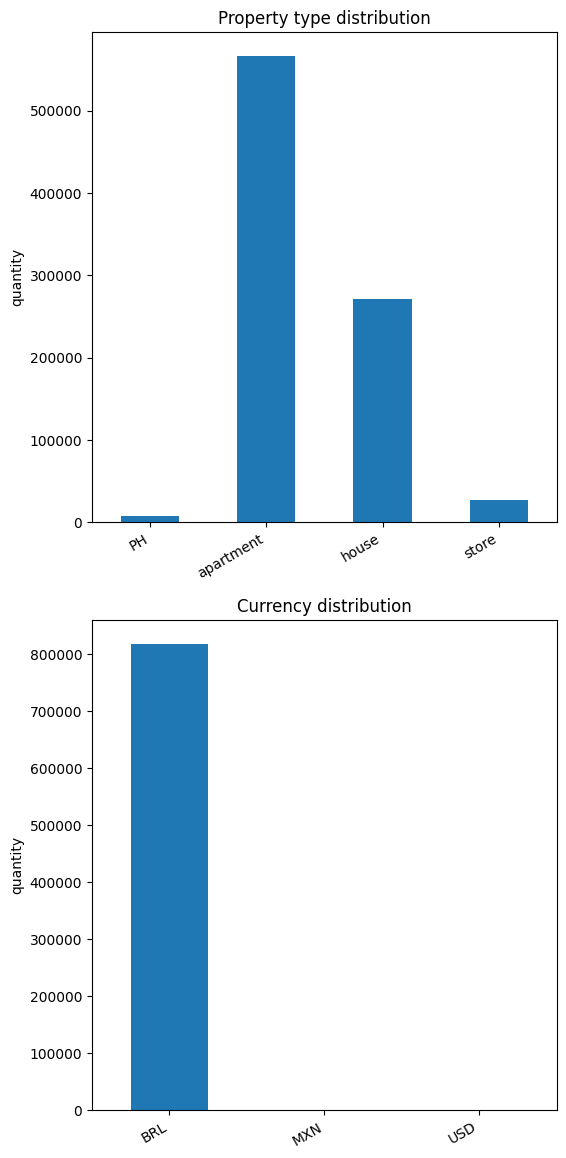

In [ ]:
fig, ax = plt.subplots(2, figsize=(6, 14))

ax[0].title.set_text("Property type distribution")
ax[0].set_ylabel("quantity")
raw_df[raw_df.property_type.notnull()].property_type.value_counts().sort_index().plot(
    kind="bar", ax=ax[0], xlabel=""
)
plt.setp(ax[0].get_xticklabels(), rotation=30, horizontalalignment="right")

ax[1].title.set_text("Currency distribution")
ax[1].set_ylabel("quantity")
raw_df[raw_df.currency.notnull()].currency.value_counts().sort_index().plot(
    kind="bar", ax=ax[1], xlabel=""
)
plt.setp(ax[1].get_xticklabels(), rotation=30, horizontalalignment="right")
fig.show()

Unbalanced values can cause problems in model performance. Because of this we are going to drop PH, stores, and non-BRL rows. For continuous features, we need to do a similar analysis.

In addition to feature selection, we will convert the `created_on` column to ordinal and convert the `property_type` column to two columns like `is_house` and `is_apartment` (one-hot encoding).

In [ ]:
clean_df = raw_df[
    raw_df.created_on.notnull()
    & raw_df.lat.notnull()
    & raw_df.lon.notnull()
    & raw_df.price.notnull()
    & raw_df.rooms.notnull()
    & raw_df.surface_covered_in_m2.notnull()
    & (raw_df.currency == "BRL")
    & ((raw_df.property_type == "apartment") | (raw_df.property_type == "house"))
][
    [
        "lat",
        "lon",
        "created_on",
        "property_type",
        "price",
        "surface_covered_in_m2",
        "rooms",
    ]
]
clean_df.created_on = clean_df.created_on.map(datetime.datetime.fromisoformat).map(
    datetime.datetime.toordinal
)
clean_df.loc[:, "is_house"] = 0
clean_df.loc[clean_df.property_type == "house", "is_house"] = 1

clean_df.loc[:, "is_apartment"] = 0
clean_df.loc[clean_df.property_type == "apartment", "is_apartment"] = 1

clean_df.drop(columns=["property_type"], inplace=True)
clean_df.head(3)

,lat,lon,created_on,price,surface_covered_in_m2,rooms,is_house,is_apartment
792,-3.474983,-38.928616,735045,5000000.0,1000.0,8.0,1,0
794,-23.547697,-46.657379,735115,2000000.0,180.0,3.0,0,1
795,-23.545349,-46.659519,735115,960000.0,109.0,3.0,0,1


Now the same analysis as before but now for continuous features.

/tmp/ipykernel_212015/2237906502.py:129: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


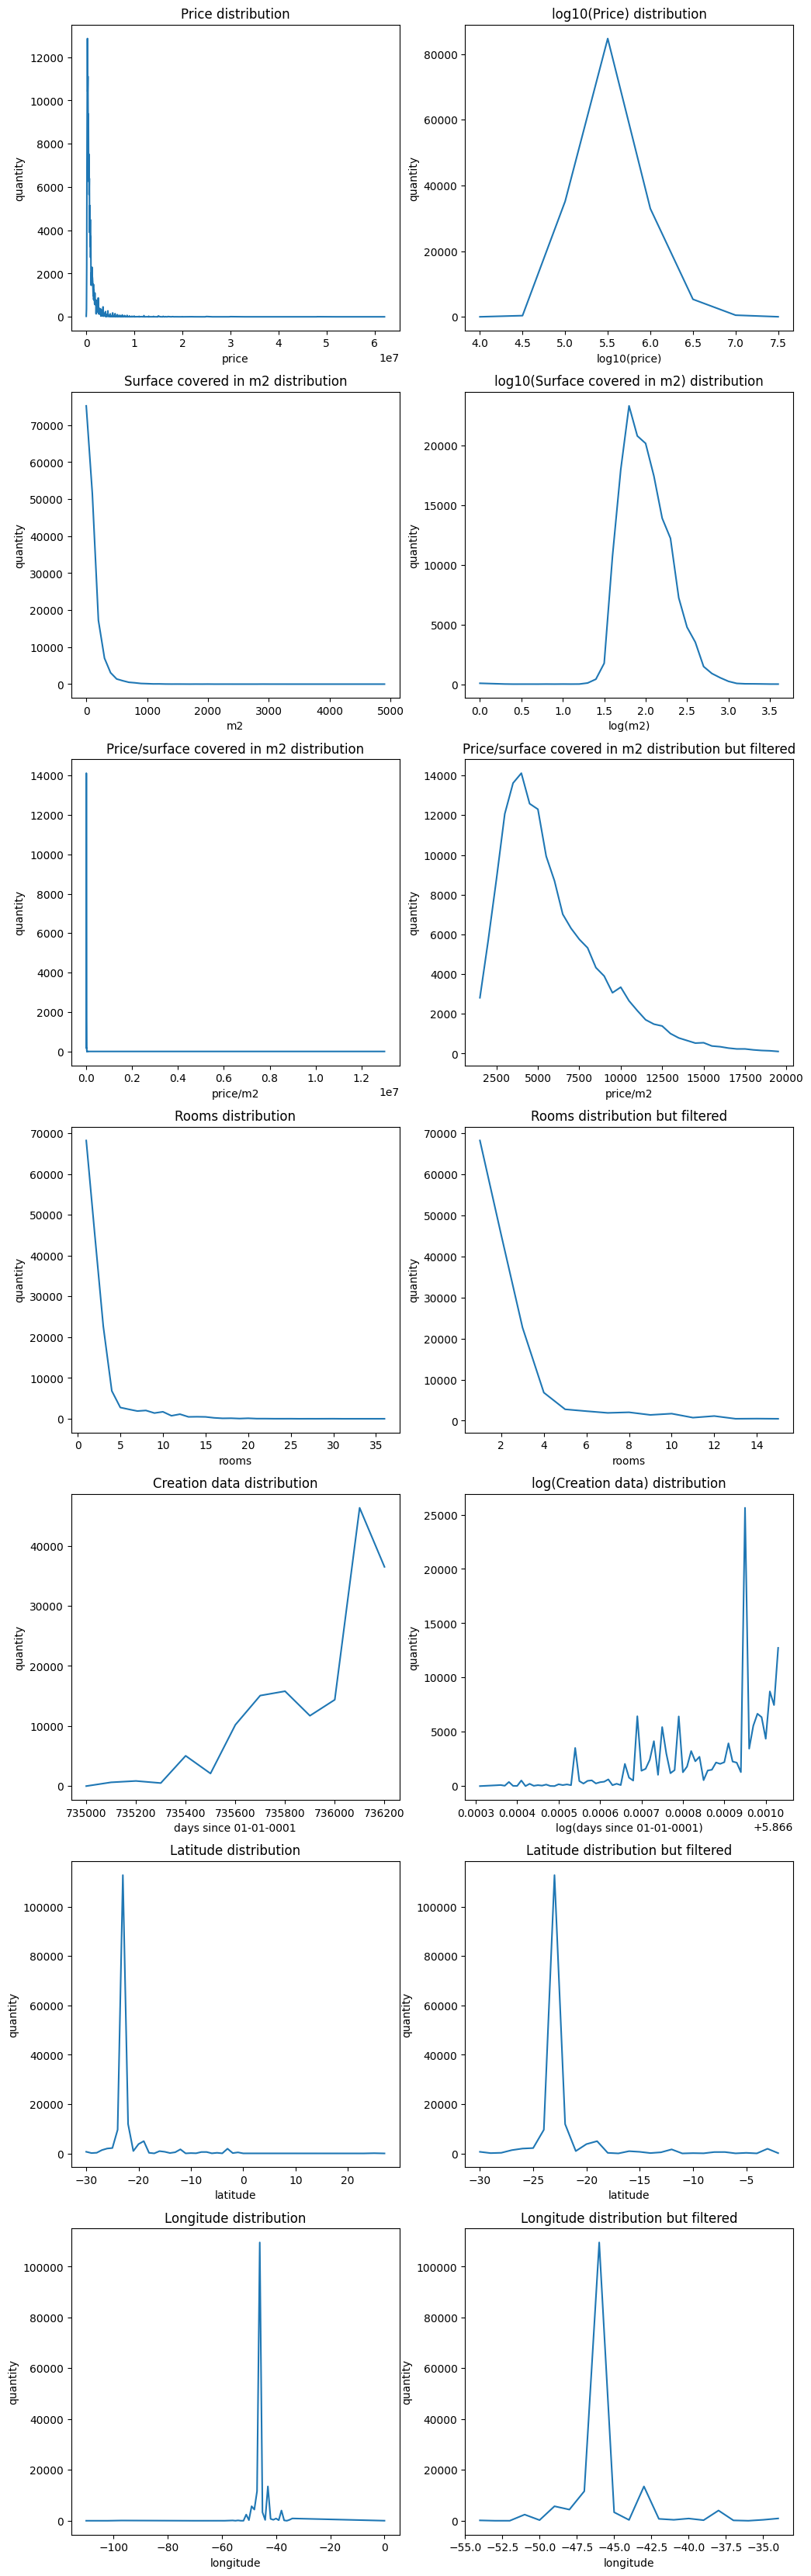

In [ ]:
def group_values(series: pd.Series, group_size: float) -> pd.Series:
    return ((series / group_size).map(int) * group_size).value_counts().sort_index()


fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(12, 42))

ax[0, 0].title.set_text("Price distribution")
ax[0, 0].set_xlabel("price")
ax[0, 0].set_ylabel("quantity")
ax[0, 0].plot(group_values(clean_df[clean_df.price > 0].price, 50000))

ax[0, 1].title.set_text("log10(Price) distribution")
ax[0, 1].set_xlabel("log10(price)")
ax[0, 1].set_ylabel("quantity")
ax[0, 1].plot(group_values(np.log10(clean_df[clean_df.price > 0].price), 0.5))

ax[1, 0].title.set_text("Surface covered in m2 distribution")
ax[1, 0].set_xlabel("m2")
ax[1, 0].set_ylabel("quantity")
ax[1, 0].plot(
    group_values(
        clean_df[
            (clean_df.surface_covered_in_m2 > 0)
            & (clean_df.surface_covered_in_m2 < 5000)
        ].surface_covered_in_m2,
        100,
    )
)

ax[1, 1].title.set_text("log10(Surface covered in m2) distribution")
ax[1, 1].set_xlabel("log(m2)")
ax[1, 1].set_ylabel("quantity")
ax[1, 1].plot(
    group_values(
        np.log10(
            clean_df[
                (clean_df.surface_covered_in_m2 > 0)
                & (clean_df.surface_covered_in_m2 < 5000)
            ].surface_covered_in_m2
        ),
        0.1,
    )
)

positive_price_and_m2 = clean_df[
    (clean_df.price > 0) & (clean_df.surface_covered_in_m2 > 0)
]

filtered_price_and_m2 = positive_price_and_m2[
    (positive_price_and_m2.price / positive_price_and_m2.surface_covered_in_m2 > 1500)
    & (
        positive_price_and_m2.price / positive_price_and_m2.surface_covered_in_m2
        < 20000
    )
]

ax[2, 0].title.set_text("Price/surface covered in m2 distribution")
ax[2, 0].set_xlabel("price/m2")
ax[2, 0].set_ylabel("quantity")
ax[2, 0].plot(
    group_values(
        positive_price_and_m2.price / positive_price_and_m2.surface_covered_in_m2,
        500,
    )
)

ax[2, 1].title.set_text("Price/surface covered in m2 distribution but filtered")
ax[2, 1].set_xlabel("price/m2")
ax[2, 1].set_ylabel("quantity")
ax[2, 1].plot(
    group_values(
        filtered_price_and_m2.price / filtered_price_and_m2.surface_covered_in_m2,
        500,
    )
)

ax[3, 0].title.set_text("Rooms distribution")
ax[3, 0].set_xlabel("rooms")
ax[3, 0].set_ylabel("quantity")
ax[3, 0].plot(group_values(clean_df.rooms, 1))

ax[3, 1].title.set_text("Rooms distribution but filtered")
ax[3, 1].set_xlabel("rooms")
ax[3, 1].set_ylabel("quantity")
ax[3, 1].plot(group_values(clean_df[clean_df.rooms < 16].rooms, 1))

ax[4, 0].title.set_text("Creation data distribution")
ax[4, 0].set_xlabel("days since 01-01-0001")
ax[4, 0].set_ylabel("quantity")
ax[4, 0].plot(
    group_values(
        clean_df.created_on,
        100,
    )
)

ax[4, 1].title.set_text("log(Creation data) distribution")
ax[4, 1].set_xlabel("log(days since 01-01-0001)")
ax[4, 1].set_ylabel("quantity")
ax[4, 1].plot(
    group_values(
        np.log10(clean_df.created_on),
        0.00001,
    )
)

ax[5, 0].title.set_text("Latitude distribution")
ax[5, 0].set_xlabel("latitude")
ax[5, 0].set_ylabel("quantity")
ax[5, 0].plot(group_values(clean_df.lat, 1))

ax[5, 1].title.set_text("Latitude distribution but filtered")
ax[5, 1].set_xlabel("latitude")
ax[5, 1].set_ylabel("quantity")
ax[5, 1].plot(group_values(clean_df[clean_df.lat < -2].lat, 1))

ax[6, 0].title.set_text("Longitude distribution")
ax[6, 0].set_xlabel("longitude")
ax[6, 0].set_ylabel("quantity")
ax[6, 0].plot(group_values(clean_df.lon, 1))

ax[6, 1].title.set_text("Longitude distribution but filtered")
ax[6, 1].set_xlabel("longitude")
ax[6, 1].set_ylabel("quantity")
ax[6, 1].plot(
    group_values(clean_df[(clean_df.lon < -34) & (clean_df.lon > -55)].lon, 1)
)

fig.show()

Note that some of those features are worth applying some non-linear normalization like logarithm. The price and the surface covered in m2 are obviously skewed. Rooms, creation date, price over m2, latitude, and longitude are not so much so I'm only going to apply some linear transformation and filtering to them. Before adding new features I want to see feature correlation to check if they make sense.


/home/cleto/repos/knn-spatial-boost/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

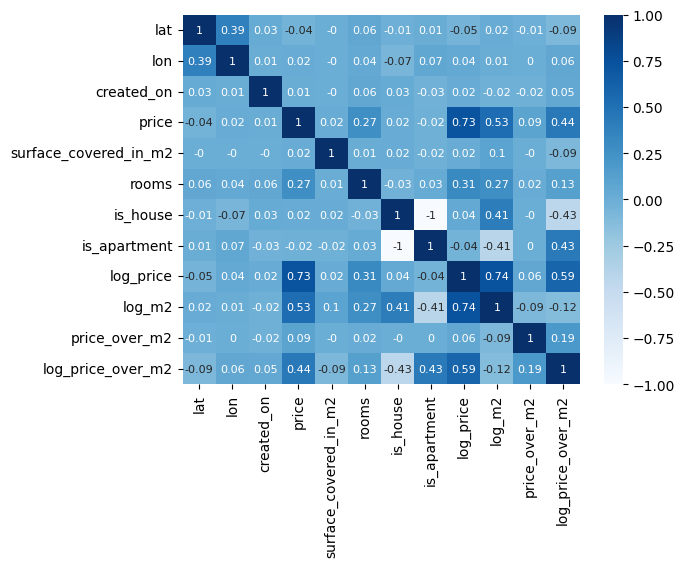

In [ ]:
corr_df = clean_df.copy()
corr_df["log_price"] = np.log10(corr_df.price)
corr_df["log_m2"] = np.log10(corr_df.surface_covered_in_m2)
corr_df["price_over_m2"] = corr_df.price / corr_df.surface_covered_in_m2
corr_df["log_price_over_m2"] = np.log10(corr_df.price / corr_df.surface_covered_in_m2)
corr = corr_df.corr().round(2)
sb.heatmap(corr, cmap="Blues", annot=True, annot_kws={"fontsize": 8})

Since `price` and `surface_covered_in_m2` are skewed I considered applying the log to them. But note that `log_price` and `log_m2` are highly correlated (0.74). If we take a look at the `price_over_m2` row in the correlation matrix, we notice that it's not highly correlated with anything and `price_over_m2` distribution is not skewed. Because of this, we are going to use it as the target column!

In [ ]:
df = corr_df[
    (corr_df.lat < -2)
    & (corr_df.lon < -34)
    & (corr_df.lon > -55)
    & (corr_df.price > 0)
    & (corr_df.rooms < 16)
    & (corr_df.price > 0)
    & (corr_df.surface_covered_in_m2 > 0)
    & (corr_df.surface_covered_in_m2 < 5000)
    & (corr_df.price_over_m2 > 1500)
    & (corr_df.price_over_m2 < 20000)
][["lat", "lon", "created_on", "rooms", "is_house", "is_apartment", "price_over_m2"]]
df.head(3)

,lat,lon,created_on,rooms,is_house,is_apartment,price_over_m2
792,-3.474983,-38.928616,735045,8.0,1,0,5000.000000
794,-23.547697,-46.657379,735115,3.0,0,1,11111.111111
795,-23.545349,-46.659519,735115,3.0,0,1,8807.339450


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153337 entries, 792 to 872640
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lat            153337 non-null  float64
 1   lon            153337 non-null  float64
 2   created_on     153337 non-null  int64  
 3   rooms          153337 non-null  float64
 4   is_house       153337 non-null  int64  
 5   is_apartment   153337 non-null  int64  
 6   price_over_m2  153337 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 9.4 MB


Here's a geographical view of the data. For future comparison, we are going to "zoom in" Belo Horizonte (BH), which is a big city, filter to only apartments with 1 room. I used logarithm in the price to show colors in a smoother way.


In [ ]:
bh_lats = (-19.99491, -19.83163)
bh_longs = (-44.02857, -43.90612)

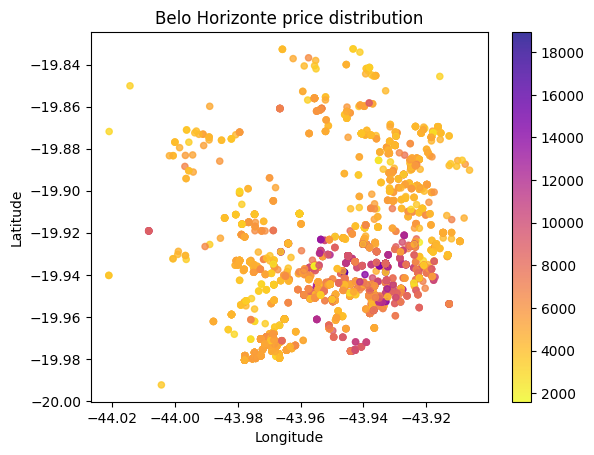

In [ ]:
bh_df = df[
    (df.lat > bh_lats[0])
    & (df.lat < bh_lats[1])
    & (df.lon > bh_longs[0])
    & (df.lon < bh_longs[1])
    & (df.is_apartment == 1)
    & (df.rooms == 1)
]
plt.scatter(
    bh_df["lon"],
    bh_df["lat"],
    s=20,
    c=bh_df["price_over_m2"],
    cmap="plasma_r",
    alpha=0.8,
)
plt.colorbar()
plt.title("Belo Horizonte price distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
min_created_on = df.created_on.min()
max_created_on = df.created_on.max()
min_lat = df.lat.min()
max_lat = df.lat.max()
min_lon = df.lon.min()
max_lon = df.lon.max()
min_rooms = df.rooms.min()
max_rooms = df.rooms.max()
min_lon = df.lon.min()
max_lon = df.lon.max()
min_price_over_m2 = df.price_over_m2.min()
max_price_over_m2 = df.price_over_m2.max()


def normalize_xs(x: pd.DataFrame) -> pd.DataFrame:
    x.created_on = (x.created_on - min_created_on) / (max_created_on - min_created_on)
    x.lat = (x.lat - min_lat) / (max_lat - min_lat)
    x.lon = (x.lon - min_lon) / (max_lon - min_lon)
    x.rooms = (x.rooms - min_rooms) / (max_rooms - min_rooms)
    return x


def normalize_y(x: pd.DataFrame) -> pd.DataFrame:
    x.price_over_m2 = (x.price_over_m2 - min_price_over_m2) / (
        max_price_over_m2 - min_price_over_m2
    )
    return x


def denormalize_y(y: np.ndarray) -> pd.DataFrame:
    return (min_price_over_m2 + y * (max_price_over_m2 - min_price_over_m2)).round(2)


def prepare(x: pd.DataFrame) -> pd.DataFrame:
    new_x = x.copy()
    return normalize_xs(normalize_y(new_x))


prepared_df = prepare(df)
prepared_df.head(3)

,lat,lon,created_on,rooms,is_house,is_apartment,price_over_m2
792,0.964141,0.793751,0.000000,0.500000,1,0,0.189147
794,0.242964,0.407479,0.057236,0.142857,0,1,0.519595
795,0.243049,0.407372,0.057236,0.142857,0,1,0.395022


Before starting training, we are going to split our dataset into a training dataset and a validation dataset.


In [ ]:
def split_dataset(
    dataset: pd.DataFrame, test_ratio: float = 0.30
) -> t.Tuple[pd.DataFrame, pd.DataFrame]:
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]


train, valid = split_dataset(prepared_df)
X_train = train.loc[:, train.columns != "price_over_m2"].to_numpy()
y_train = train.price_over_m2.to_numpy()
X_valid = valid.loc[:, valid.columns != "price_over_m2"].to_numpy()
y_valid = valid.price_over_m2.to_numpy()
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(107424, 6)
(107424,)
(45913, 6)
(45913,)


## Sanity checks

Even with the validation dataset, we want to make some sanity checks after the training. To do it so, we built this function which evaluates the model with specific features. It's a _curried_ function because there are some standardized checks to apply to all models.


In [ ]:
def eval(
    lat: t.Union[float, np.ndarray],
    lon: t.Union[float, np.ndarray],
    created_on: t.Union[datetime.date, t.List[datetime.date]],
    property_type: t.Literal["apartment", "house"],
    rooms: t.Union[int, np.ndarray],
) -> t.Callable[[t.Any], pd.DataFrame]:
    lat_vec = lat if isinstance(lat, np.ndarray) else np.array([lat])
    lon_vec = lon if isinstance(lon, np.ndarray) else np.array([lon])
    created_on_vec = (
        np.array([c.toordinal() for c in created_on])
        if isinstance(created_on, t.List)
        else np.array([created_on.toordinal()])
    )
    rooms_vec = rooms if isinstance(rooms, np.ndarray) else np.array([rooms])

    m = np.vstack(
        [
            v.ravel()
            for v in np.meshgrid(
                lat_vec,
                lon_vec,
                created_on_vec,
                rooms_vec,
                indexing="ij",
            )
        ]
    ).T

    is_apartment = int(property_type == "apartment")
    is_house = int(property_type == "house")

    x_df = pd.DataFrame(
        {
            "lat": m[:, 0],
            "lon": m[:, 1],
            "created_on": m[:, 2],
            "is_apartment": [is_apartment] * len(m),
            "is_house": [is_house] * len(m),
            "rooms": m[:, 3],
        }
    )
    x = normalize_xs(x_df.copy()).to_numpy()

    def fn(model: t.Any) -> pd.DataFrame:
        y = model.predict(x)
        x_df["price_over_m2"] = denormalize_y(y.reshape(len(m)))
        return x_df

    return fn

Here are all sanity checks:


In [ ]:
lats = np.linspace(bh_lats[0], bh_lats[1], 100)
longs = np.linspace(bh_longs[0], bh_longs[1], 50)

santacruz = (-19.87755, -43.94184)
sion = (-19.95408, -43.93163)

start = datetime.date(2013, 7, 1)
date_list = [start + datetime.timedelta(days=x) for x in range(365 * 3)]

bh_heatmap_check = eval(lats, longs, datetime.date(2016, 1, 1), "apartment", 1)
santa_cruz_price_evolution = eval(
    santacruz[0], santacruz[1], date_list, "apartment", np.array([1, 2, 3])
)
sion_price_evolution = eval(
    sion[0], sion[1], date_list, "apartment", np.array([1, 2, 3])
)

Here's a function to plot everything once:


In [ ]:
def sanity_checks(model: t.Any, price_limit: t.Optional[float] = None) -> None:
    bh_heatmap = bh_heatmap_check(model)
    santa_cruz = santa_cruz_price_evolution(model)
    sion = sion_price_evolution(model)

    if price_limit is not None:
        bh_heatmap.loc[bh_heatmap.price > price_limit, "price"] = price_limit

    fig, ax = plt.subplots(3, figsize=(6, 13))
    fig.tight_layout(pad=5.0)

    ax[0].title.set_text("BH price heatmap")
    ax[0].set_xlabel("Longitude")
    ax[0].set_ylabel("Latitude")
    scatter = ax[0].scatter(
        bh_heatmap["lon"],
        bh_heatmap["lat"],
        s=20,
        c=bh_heatmap["price_over_m2"],
        cmap="plasma_r",
        alpha=0.8,
        **(
            {"norm": colors.Normalize(vmin=0, vmax=price_limit)}
            if price_limit is not None
            else {}
        )
    )
    fig.colorbar(scatter)
    plt.setp(ax[0].get_xticklabels(), rotation=30, horizontalalignment="right")

    ax[1].title.set_text("Santa Cruz price/m2 evolution")
    ax[1].set_xlabel("Date")
    ax[1].set_ylabel("Price/m2")
    ax[1].plot(
        date_list,
        santa_cruz[santa_cruz.rooms == 1].price_over_m2.rolling(30).mean(),
        label="1 room",
    )
    ax[1].plot(
        date_list,
        santa_cruz[santa_cruz.rooms == 2].price_over_m2.rolling(30).mean(),
        label="2 rooms",
    )
    ax[1].plot(
        date_list,
        santa_cruz[santa_cruz.rooms == 3].price_over_m2.rolling(30).mean(),
        label="3 rooms",
    )
    ax[1].legend()
    plt.setp(ax[1].get_xticklabels(), rotation=30, horizontalalignment="right")

    ax[2].title.set_text("Sion price/m2 evolution")
    ax[2].set_xlabel("Date")
    ax[2].set_ylabel("Price/m2")
    ax[2].plot(
        date_list,
        sion[sion.rooms == 1].price_over_m2.rolling(30).mean(),
        label="1 room",
    )
    ax[2].plot(
        date_list,
        sion[sion.rooms == 2].price_over_m2.rolling(30).mean(),
        label="2 rooms",
    )
    ax[2].plot(
        date_list,
        sion[sion.rooms == 3].price_over_m2.rolling(30).mean(),
        label="3 rooms",
    )
    ax[2].legend()
    plt.setp(ax[2].get_xticklabels(), rotation=30, horizontalalignment="right")

    fig.show()

## Random Forest

We are going to give a try to the Random Forest model.


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# | notest
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=0)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, random_state=0)

In [ ]:
# | hide
# | notest
pickle.dump(rf, open("rf.pickle", "wb"))

In [ ]:
# | hide
rf = pickle.load(open("rf.pickle", "rb"))

In [ ]:
rf.score(X_valid, y_valid)

0.7391105641168709

/tmp/ipykernel_212015/1983228620.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


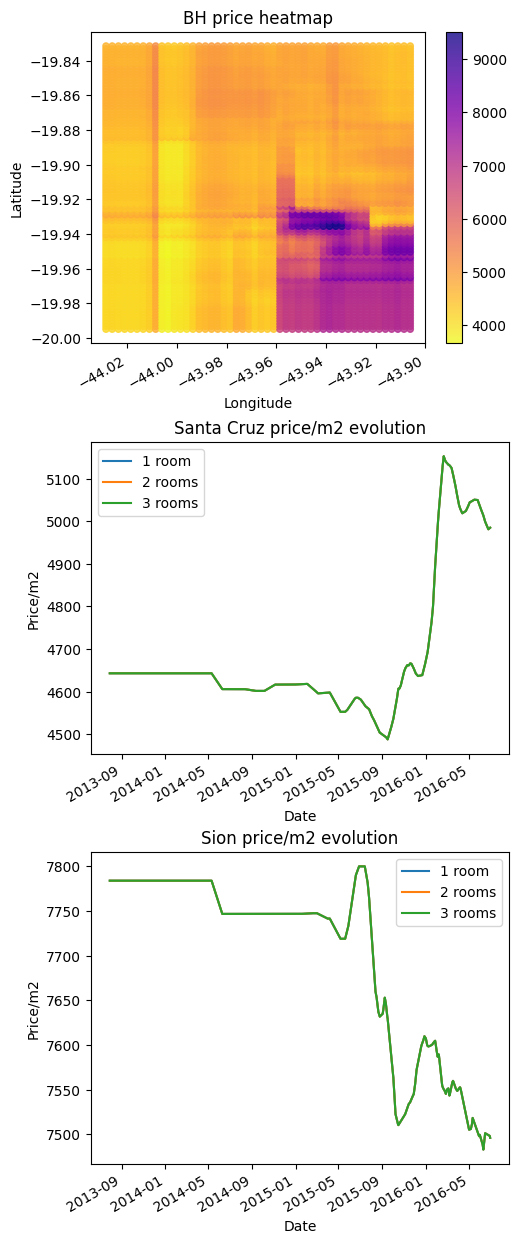

In [ ]:
sanity_checks(rf)

Even with the high score, the model behavior is absolutely bad.

**BH price heatmap**: The model struggled to learn information from coordinates and built rectangular patterns. To get a more precise rectangular segmentation we need to increase `max_depth` and `n_estimators` to allow the model to store more information about the coordinates.

**Price evolution**: In both plots, the model cannot see the price difference between 1, 2, and 3 rooms. In real life every location got more expensive from 2013 to 2016 but for the model, the price doesn't go up.

I believe it happened because of three reasons:

1) Lack of generalization capabilities in the RF model;
2) Lack of data;
3) RF can learn a limited amount of information given `max_depth` and `n_estimators`. To increase it is necessary to raise `max_depth` and `n_estimators`. Unfortunately, it will increase the model size (which currently is 127 MB), increase time to train, increase time to inference, increase RAM usage, and can overfit the model.

Going beyond this point is not worth it. It makes RF not suitable for geospatial data with only coordinates.


## KNN

We are going to give it a try to KNN.


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# | notest
knn = KNeighborsRegressor(n_neighbors=15, weights="distance")
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15, weights='distance')

In [ ]:
# | hide
# | notest
pickle.dump(knn, open("knn.pickle", "wb"))

In [ ]:
# | hide
knn = pickle.load(open("knn.pickle", "rb"))

In [ ]:
knn.score(X_valid, y_valid)

0.6321752472080835

/tmp/ipykernel_212015/1983228620.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


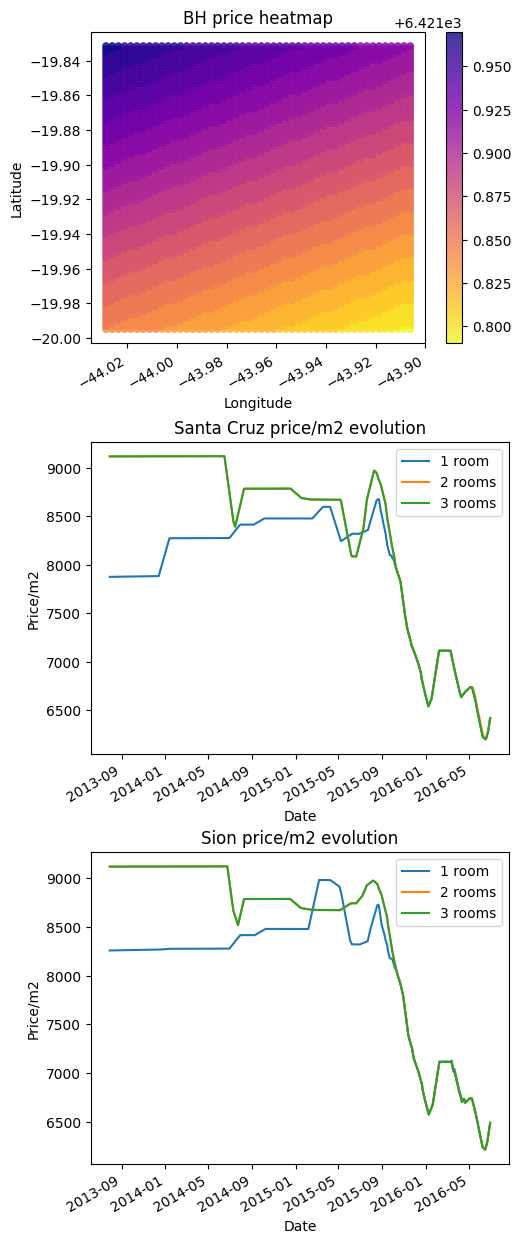

In [ ]:
sanity_checks(knn)

Low score and bad model behavior.

**BH price heatmap**: The model struggled to learn information from coordinates (maybe because of other features that are not geospatial coordinates) and built a random surface. Even lowering our expectations and allowing for a "low-resolution heatmap" the price should be higher at the bottom of the figure, not lower.

**Price evolution**: In both plots, the model cannot see too much price difference between 1, 2 and 3 rooms. The price is the same for a well-known expensive location and a well-known cheap location. In real life, every location got more expensive from 2013 to 2016 but for the model, the price doesn't go up. Instead of it, the price goes up and down "randomly".

This model can "learn" a lot of information but cannot learn the patterns from them.


## Neural Networks

We are going to give it a try to neural networks.


In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
# | notest
nn = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32, 16),
    verbose=True,
    max_iter=200,
    batch_size=32,
    early_stopping=True,
    random_state=0,
)

nn.fit(X_train, y_train)

Iteration 1, loss = 0.01155141
Validation score: 0.221862
Iteration 2, loss = 0.01088603
Validation score: 0.212346
Iteration 3, loss = 0.01077097
Validation score: 0.243658
Iteration 4, loss = 0.01061189
Validation score: 0.262032
Iteration 5, loss = 0.01034798
Validation score: 0.275889
Iteration 6, loss = 0.00965983
Validation score: 0.314949
Iteration 7, loss = 0.00913479
Validation score: 0.402566
Iteration 8, loss = 0.00878743
Validation score: 0.365734
Iteration 9, loss = 0.00846887
Validation score: 0.323008
Iteration 10, loss = 0.00835023
Validation score: 0.457188
Iteration 11, loss = 0.00822268
Validation score: 0.450064
Iteration 12, loss = 0.00813812
Validation score: 0.429624
Iteration 13, loss = 0.00803822
Validation score: 0.208194
Iteration 14, loss = 0.00809019
Validation score: 0.464554
Iteration 15, loss = 0.00811037
Validation score: 0.381254
Iteration 16, loss = 0.00806553
Validation score: 0.448898
Iteration 17, loss = 0.00805290
Validation score: 0.461965
Iterat

MLPRegressor(batch_size=32, early_stopping=True,
             hidden_layer_sizes=(128, 64, 32, 16), random_state=0,
             verbose=True)

In [ ]:
# | hide
# | notest
pickle.dump(nn, open("nn.pickle", "wb"))

In [ ]:
# | hide
nn = pickle.load(open("nn.pickle", "rb"))

In [ ]:
nn.score(X_valid, y_valid)

0.5273335291341406

/tmp/ipykernel_341749/1983228620.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


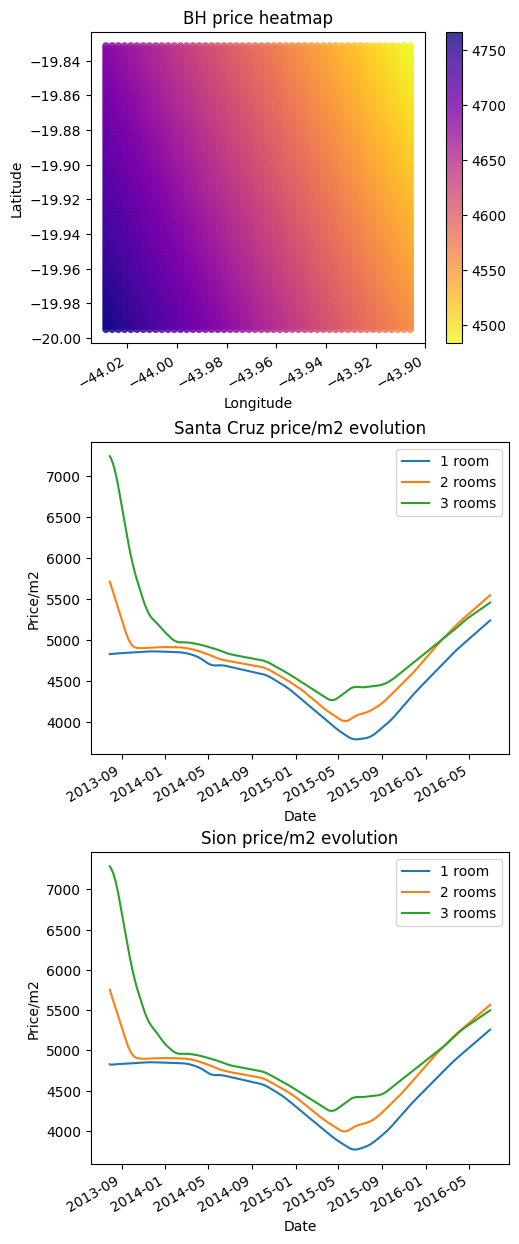

In [ ]:
sanity_checks(nn)

Low score and bad model behavior.

**BH price heatmap**: The model struggled to learn information from coordinates and built a "random" surface. Even lowering our expectations and allowing a "low-resolution heatmap" the price should be higher on the right of the figure, not left.

**Price evolution**: The model ordered rooms almost OK but there's not much price difference between 1, 2 and 3 rooms. The price is the same for a well-known expensive location and a well-known cheap location. In real life, every location got more expensive from 2013 to 2016 but for the model, the price goes down.

To allow the neural network to learn the patterns from the coordinates we will need a lot more parameters and running time.

PS: I attempted to run a neural network with the architecture 6-2000-2000-2000-1 on my notebook's graphics card, but I did not see any improvement in the score even with more than 1 hour of train time.


## Spatial Boosted Random Forest


Here's where things got interesting. Since the "KKN Spatial Booster" increases model spatial awareness we can get a lot better behaviour.

In [ ]:
from knn_spatial_boost.core import KNNSpatialBooster

In [ ]:
# | notest
boosted_rf = KNNSpatialBooster(
    n_neighbors=1,
    temperature=0.5,
    n_loops=1,
    spatial_features=[0, 1],
    remove_target_spatial_cols=True,
    remove_neighbor_spatial_cols=True,
    estimator=RandomForestRegressor(n_estimators=100, max_depth=15, random_state=0),
)

boosted_rf.fit(X_train, y_train)

Running loop #0


In [ ]:
# | hide
# | notest
pickle.dump(boosted_rf, open("boosted_rf.pickle", "wb"))

In [ ]:
# | hide
boosted_rf = pickle.load(open("boosted_rf.pickle", "rb"))

In [ ]:
boosted_rf.score(X_valid, y_valid)

0.6462122118094535

/tmp/ipykernel_341749/1983228620.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


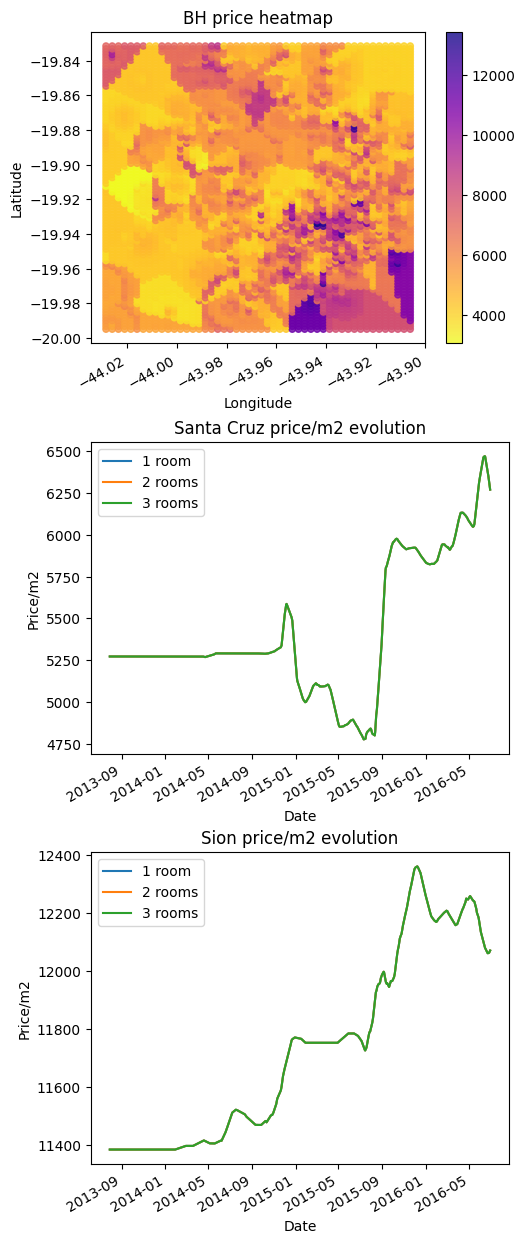

In [ ]:
sanity_checks(boosted_rf)

Better model behavior but lower score.

**BH price heatmap**: Now we have a picture that looks like a city and not a "random" surface. The more expensive region of the city is darker, which is a great sign.

**Price evolution**: In both plots, the model cannot see the price difference between 1, 2, and 3 rooms. In real life every location got more expensive from 2013 to 2016 but for the model, the price doesn't go up. Instead of it, the price goes up and down "randomly".

Even with the spatial boost, looks like RF is not the right algorithm to deal with this problem because of its lack of generalization capabilities. It's a calculation problem and all NNs do are calculations. That's why we are going to try it with the spatial booster.


## Spatial Boosted Neural Network


In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
# | notest
boosted_nn = KNNSpatialBooster(
    n_neighbors=1,
    temperature=0.5,
    n_loops=10,
    spatial_features=[0, 1],
    remove_target_spatial_cols=True,
    remove_neighbor_spatial_cols=True,
    estimator=MLPRegressor(
        hidden_layer_sizes=(64, 32, 16, 8),
        warm_start=True,
        early_stopping=True,
        tol=1e-10,
        n_iter_no_change=20,
        verbose=True,
        max_iter=10,
        batch_size=32,
        random_state=0,
    ),
)

boosted_nn.fit(X_train, y_train)

Running loop #0
Iteration 1, loss = 0.01076201
Validation score: 0.639482
Iteration 2, loss = 0.00505485
Validation score: 0.646830
Iteration 3, loss = 0.00502750
Validation score: 0.606791
Iteration 4, loss = 0.00499496
Validation score: 0.594461
Iteration 5, loss = 0.00496672
Validation score: 0.654910
Iteration 6, loss = 0.00493094
Validation score: 0.651485
Iteration 7, loss = 0.00491670
Validation score: 0.631484
Iteration 8, loss = 0.00488778
Validation score: 0.656580
Iteration 9, loss = 0.00488642
Validation score: 0.640114
Iteration 10, loss = 0.00487413
Validation score: 0.654056
Running loop #1


/home/cleto/repos/knn-spatial-boost/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00492030
Validation score: 0.657268
Iteration 2, loss = 0.00489820
Validation score: 0.659917
Iteration 3, loss = 0.00490151
Validation score: 0.657331
Iteration 4, loss = 0.00489341
Validation score: 0.662173
Iteration 5, loss = 0.00487561
Validation score: 0.660516
Iteration 6, loss = 0.00487458
Validation score: 0.653273
Iteration 7, loss = 0.00486312
Validation score: 0.663242
Iteration 8, loss = 0.00486511
Validation score: 0.656660
Iteration 9, loss = 0.00485934
Validation score: 0.661999
Iteration 10, loss = 0.00484734
Validation score: 0.650012
Running loop #2


/home/cleto/repos/knn-spatial-boost/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00484281
Validation score: 0.658492
Iteration 2, loss = 0.00483870
Validation score: 0.660877
Iteration 3, loss = 0.00483310
Validation score: 0.661852
Iteration 4, loss = 0.00482470
Validation score: 0.661438
Iteration 5, loss = 0.00481553
Validation score: 0.651800
Iteration 6, loss = 0.00481803
Validation score: 0.646303
Iteration 7, loss = 0.00480763
Validation score: 0.662768
Iteration 8, loss = 0.00480969
Validation score: 0.663732
Iteration 9, loss = 0.00480441
Validation score: 0.660551
Iteration 10, loss = 0.00479137
Validation score: 0.660748
Running loop #3


/home/cleto/repos/knn-spatial-boost/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00482647
Validation score: 0.657868
Iteration 2, loss = 0.00483086
Validation score: 0.658173
Iteration 3, loss = 0.00482533
Validation score: 0.661644
Iteration 4, loss = 0.00481965
Validation score: 0.660866
Iteration 5, loss = 0.00481187
Validation score: 0.654417
Iteration 6, loss = 0.00481857
Validation score: 0.648055
Iteration 7, loss = 0.00481070
Validation score: 0.659433
Iteration 8, loss = 0.00481106
Validation score: 0.660187
Iteration 9, loss = 0.00480457
Validation score: 0.660062
Iteration 10, loss = 0.00479852
Validation score: 0.657204
Running loop #4


/home/cleto/repos/knn-spatial-boost/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.00477730
Validation score: 0.647587
Iteration 2, loss = 0.00477892
Validation score: 0.657816
Iteration 3, loss = 0.00477693
Validation score: 0.653692
Iteration 4, loss = 0.00477174
Validation score: 0.646146
Iteration 5, loss = 0.00476712
Validation score: 0.646889
Iteration 6, loss = 0.00477756
Validation score: 0.657485
Iteration 7, loss = 0.00476419
Validation score: 0.657585
Iteration 8, loss = 0.00476931
Validation score: 0.659595
Iteration 9, loss = 0.00476752
Validation score: 0.658798
Validation score did not improve more than tol=0.000000 for 20 consecutive epochs. Stopping.
Running loop #5
Iteration 1, loss = 0.00478566
Validation score: 0.654872
Validation score did not improve more than tol=0.000000 for 20 consecutive epochs. Stopping.
Running loop #6
Iteration 1, loss = 0.00476722
Validation score: 0.659148
Validation score did not improve more than tol=0.000000 for 20 consecutive epochs. Stopping.
Running loop #7
Iteration 1, loss = 0.00477244
Vali

In [ ]:
# | hide
# | notest
pickle.dump(boosted_nn, open("boosted_nn.pickle", "wb"))

In [ ]:
# | hide
boosted_nn = pickle.load(open("boosted_nn.pickle", "rb"))

In [ ]:
boosted_nn.score(X_valid, y_valid)

0.6188857129459122

/tmp/ipykernel_341749/1983228620.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


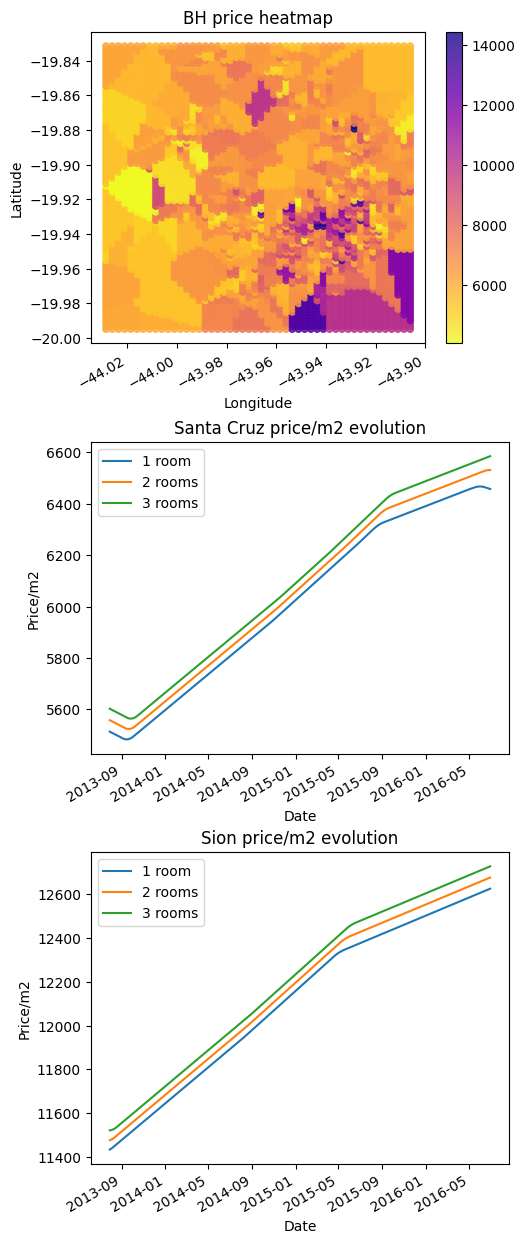

In [ ]:
sanity_checks(boosted_nn)

Best model behavior but low score.

**BH price heatmap**: Now we have a picture that looks like a city and not a "random" surface. The more expensive region of the city is darker, which is a great sign.

**Price evolution**: Curves correct order (3 rooms are more expensive than 2 rooms). Correct behavior over time since the price goes up.

Everything looks good but the scores in both training and validation datasets are poor. Note that we decided to use only the first neighbor and maybe there's not enough context to the model to calculate a final price. To increase the number of neighbors we need to increase the NN size because it cannot handle this amount of information.


## Spatial Boosted Neural Network (Bigger Architecture)

When trying to increase the number of neighbors and the number of neurons in each layer my CPU started struggling. The SciKit Learn implementation of NN is CPU-only so I tried Tensorflow and Keras to use my GPU.

I tested a lot of neighbor quantities with the 2000-2000-2000-1 architecture (and built a table with training score, validation score, etc, but I lost it) and figured out that 4 is the ideal number of neighbors for that amount of neurons and layers.

In [ ]:
keras_nn = tf.keras.models.Sequential()
keras_nn.add(tf.keras.layers.Dense(2000, activation="relu", input_shape=(28,)))
keras_nn.add(tf.keras.layers.Dropout(rate=0.01))
keras_nn.add(tf.keras.layers.Dense(2000, activation="relu"))
keras_nn.add(tf.keras.layers.Dense(2000, activation="relu"))
keras_nn.add(tf.keras.layers.Dense(1, activation="linear"))

# Compile the model
keras_nn.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=[tf.keras.metrics.R2Score()],
)

In [ ]:
# | notest
boosted_keras_nn = KNNSpatialBooster(
    n_neighbors=4,
    temperature=0.5,
    n_loops=33,
    spatial_features=[0, 1],
    remove_target_spatial_cols=True,
    remove_neighbor_spatial_cols=True,
    estimator=keras_nn,
)

boosted_keras_nn.fit(X_train, y_train)

Running loop #0
3357/3357 [==============================] - 68s 19ms/step - loss: 0.0115 - r2_score: 0.5864
Running loop #1
3357/3357 [==============================] - 63s 19ms/step - loss: 0.0083 - r2_score: 0.7024
Running loop #2
3357/3357 [==============================] - 63s 19ms/step - loss: 0.0082 - r2_score: 0.7041
Running loop #3
3357/3357 [==============================] - 64s 19ms/step - loss: 0.0082 - r2_score: 0.7067
Running loop #4
3357/3357 [==============================] - 64s 19ms/step - loss: 0.0081 - r2_score: 0.7097
Running loop #5
3357/3357 [==============================] - 64s 19ms/step - loss: 0.0081 - r2_score: 0.7101
Running loop #6
3357/3357 [==============================] - 64s 19ms/step - loss: 0.0080 - r2_score: 0.7121
Running loop #7
3357/3357 [==============================] - 65s 19ms/step - loss: 0.0080 - r2_score: 0.7118
Running loop #8
3357/3357 [==============================] - 65s 19ms/step - loss: 0.0080 - r2_score: 0.7134
Running loop #9
335

In [ ]:
# | hide
# | notest
pickle.dump(boosted_keras_nn, open("boosted_keras_nn.pickle", "wb"))

In [ ]:
# | hide
boosted_keras_nn = pickle.load(open("boosted_keras_nn.pickle", "rb"))

In [ ]:
boosted_keras_nn.score(X_valid, y_valid)

1435/1435 [==============================] - 8s 5ms/step - loss: 0.0078 - r2_score: 0.7193


[0.007787229958921671, 0.7192660570144653]

103/103 [==============================] - 0s 4ms/step


/tmp/ipykernel_341749/1983228620.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


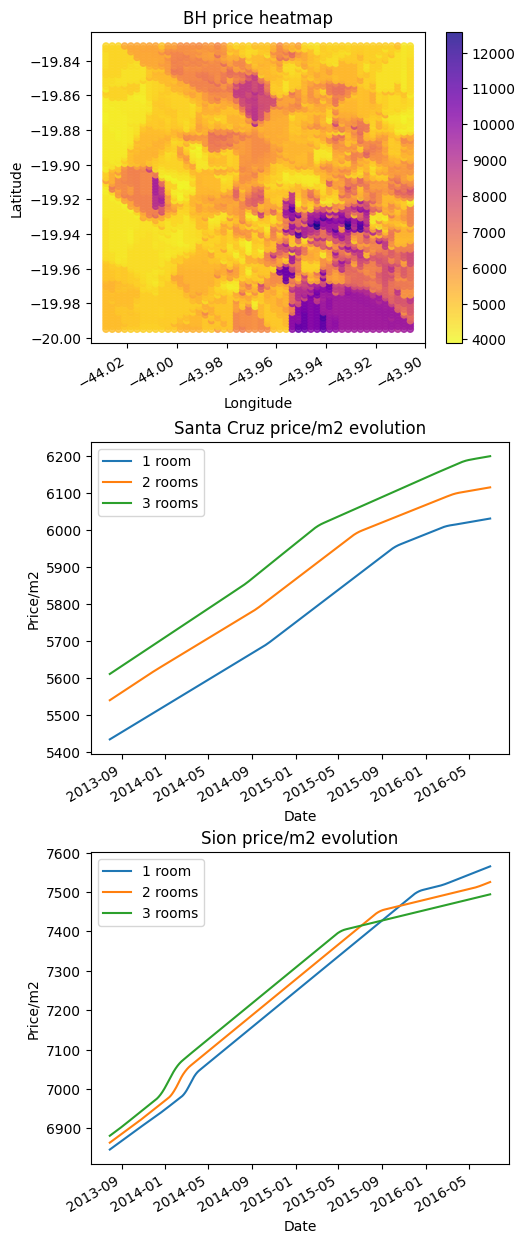

In [ ]:
sanity_checks(boosted_keras_nn)

## Conclusion

| Model                                                | Time to train | Score | BH check                         | Santa Cruz and Sion check                                                             |
| ---------------------------------------------------- | ------------- | ----- | -------------------------------- | ------------------------------------------------------------------------------------- |
| Random Forest                                        | 35.1s         | 0.739 | Vertical and horizontal patterns | Colapsing curves going up and down|
| KNN                                                  | 0.3s          | 0.632 | Random smooth surface            | Curves going up and down|
| Neural Network                                       | 7m42.4s       | 0.521 | Random smooth surface            | Correct curve order but they go up and down and the same price for different places|
| Spatial Boosted Random Forest                        | 44.3s         | 0.647 | Seems natural                    | Colapsing random curves|
| Spatial Boosted Neural Network                       | 7m16s         | 0.619 | Seems natural                    | Correct order and arguable price evolution and price difference between places        |
| Spatial Boosted Neural Network (Bigger Architecture) | 35m56.1s      | 0.719 | Seems natural                    | Almost correct order and arguable price evolution and price difference between places        |


RF had the best score but with a little bit more investigation we see a bad geospatial generalization and no price difference when adding more rooms. It seems to overfit but due to a lack of data and not to a model inability. We need more spatial features like distance to the nearest city center, hospital, school, public transportation, etc.

KNN had the best time to train but struggled with all other evaluation criteria.

NN seems to underfit. It's expected given the time to train and the complexity of understanding price fluctuation given only coordinates. It's possible to fit a NN with this data but only with a lot more time to train and a bigger architecture.

Instead of adding spatial features like distance to the nearest city center, I decided to use KNN to increase model spatial awareness by adding neighbors as features. In addition, I implemented neighbor randomness to improve model generalization.

Spatial Boosted RF had better geospatial generalization but again seems to overfit due to lack of data.

As NNs have greater generalization capacity, in the end, Spatial Boosted NN was the model that best managed to learn the patterns even with little data. It had the best qualitative performance even scoring worse than other models. The bigger version of it managed to score closer to the RF (0.719).


## Improvements & Ideas

I believe we can encode spatial data in better ways. As we can see [here](https://www.uber.com/en-DE/blog/deepeta-how-uber-predicts-arrival-times/), we can use coordinates as discrete cells, calculate embeddings for them, and use them in a transformer. Maybe in the future, I will try to reproduce this technique for this problem.

### About this research

- Generate a GIF to show price evolution through time.
- Add an online demo for portfolio purposes.
- `description` column can be used with NLP.

### About the method

- Identify the way this method affects the base model (needs more tuning?).
- Try another dataset to figure out which kind of problem suits better with the technique.
